In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def computehoughTransformCoord(x1, y1, x2, y2):
    k_inv =  (x1 - x2) / (y1 - y2)
    theta = np.arctan(-k_inv)
    X0 = - k_inv * y1 + x1

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = C / length
    if X0 < 0:
        rho = -rho
    
    return theta, length, rho

C:\Users\Yang Jiaye\AppData\Local\Temp\ipykernel_8556\1803324493.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  k_inv =  (x1 - x2) / (y1 - y2)


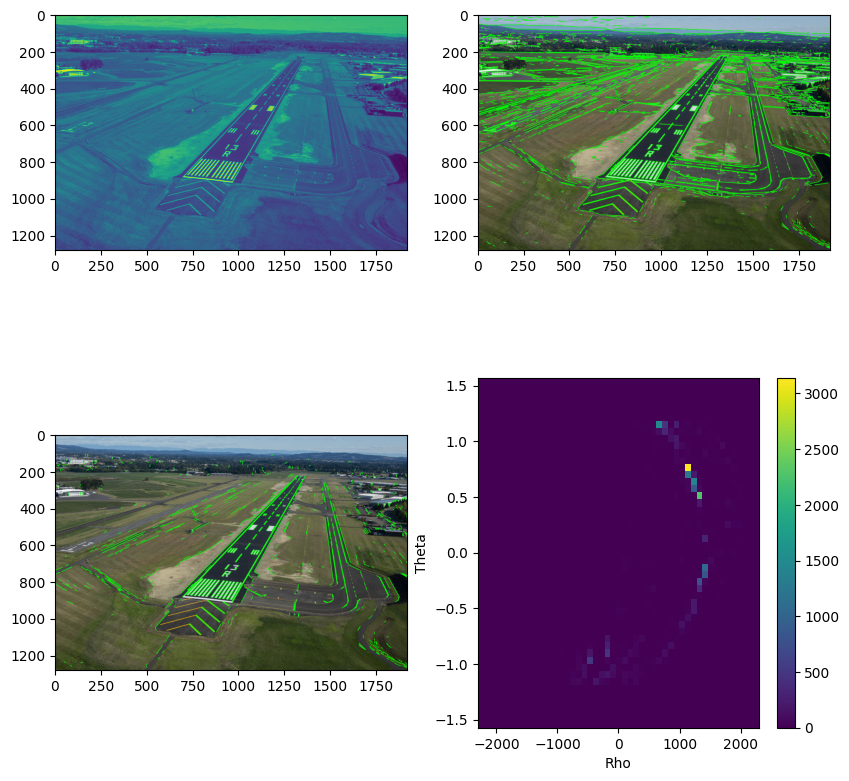

最大元素的行索引和列索引： (36, 36)
第二大元素的行索引和列索引： (32, 38)


In [10]:
img = cv2.imread("images/5.jpg")
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,0]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lsd = cv2.createLineSegmentDetector(0)
lines, width, prec, nfa = lsd.detect(gray)

plt.figure(figsize=[10, 10])
plt.subplot(2, 2, 1)
plt.imshow(gray)

drawn_img = img.copy()
for line in lines:
    x1, y1, x2, y2 = map(int, line[0])
    drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))

LLL = 2

thetaList = []
dList = []
rhoList = []
lineList = []
for line in lines:
    line = line[0]
    theta, d, rho = computehoughTransformCoord(line[0], line[1], line[2], line[3])
    if d < LLL:
        continue
    if abs(np.abs(theta) - np.pi/2) < np.pi / 8 or np.abs(theta) > 1.5707963:
        continue
    thetaList.append(theta)
    dList.append(d)
    rhoList.append(rho)
    lineList.append(line)

drawn_img = img.copy()
for line in lineList:
    x1, y1, x2, y2 = map(int, line)
    if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < 0:
        continue
    drawn_img = cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))

N = 50
Ntheta = N
Nrho = N
maxRho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
# 创建一个网格
theta_bins = np.linspace(-np.pi/2, np.pi/2, num=Ntheta)
rho_bins = np.linspace(-maxRho, maxRho, num=Nrho)
grid = np.zeros((len(theta_bins) - 1, len(rho_bins) - 1))
TRgrid = [[[] for _ in range(len(rho_bins) - 1)] for _ in range(len(theta_bins) - 1)]

# 映射thetaList和rhoList到网格中
for theta, rho, d, line in zip(thetaList, rhoList, dList, lineList):
    theta_idx = np.digitize(theta, theta_bins) - 1
    rho_idx = np.digitize(rho, rho_bins) - 1
    # print(theta, rho, theta_idx, rho_idx)
    grid[theta_idx, rho_idx] += d
    TRgrid[theta_idx][rho_idx].append((theta, rho, line, d))

# 绘制热力图
plt.subplot(2, 2, 4)
plt.imshow(grid, extent=(rho_bins[0], rho_bins[-1], theta_bins[0], theta_bins[-1]), aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Rho')
plt.ylabel('Theta')
plt.show()

# 找到最大元素的索引
max_index = np.unravel_index(np.argmax(grid), grid.shape)
max_d = grid[max_index]

# 将最大元素设为负无穷
grid[max_index] = -np.inf

# 找到第二大元素的索引
second_max_index = np.unravel_index(np.argmax(grid), grid.shape)
second_max_d = grid[second_max_index]

grid[second_max_index] = -np.inf

third_max_index = np.unravel_index(np.argmax(grid), grid.shape)
third_max_d = grid[third_max_index]

# 输出最大元素和第二大元素的行索引和列索引
print("最大元素的行索引和列索引：", max_index)
print("第二大元素的行索引和列索引：", second_max_index)


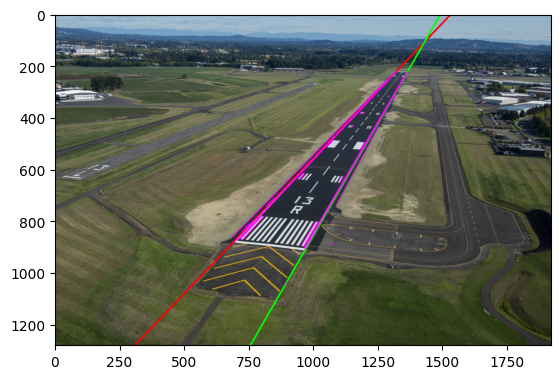

In [14]:
def drawResult(grid: list, lineImg, color = (0, 0, 255)):
    # 假设 max_index 是一个包含多个元组 (theta, rho) 的列表
    thetas = [pair[0] for pair in grid]
    rhos = [pair[1] for pair in grid]
    lines = [pair[2] for pair in grid]
    ds = [pair[3] for pair in grid]

    # x = []
    # y = []
    # weights = []
    # for line, d in zip(lines, ds):
    #     x.append(line[0])
    #     x.append(line[2])
    #     y.append(line[1])
    #     y.append(line[3])
    #     weights.append(d)
    #     weights.append(d)

    # A = np.vstack([x, np.ones(len(x))]).T
    # w = np.diag(np.sqrt(weights))
    # m, c = np.linalg.lstsq(w @ A, y @ w, rcond=None)[0]
    # print(m , c)

    thetas = np.asarray(thetas)
    rhos = np.asarray(rhos)
    ds = np.asarray(ds)
    
    theta = np.sum(thetas * ds)/np.sum(ds)
    rho = np.sum(rhos * ds)/np.sum(ds)

    m = 1/np.tan(-theta)
    c = rho / np.sin(theta)
    
    # 在图像上绘制直线
    LL = 3000
    cv2.line(lineImg, (0, int(c)), (LL, int( LL *m + c)), color, 5)
    for line, d in zip(lines, ds):
        cv2.line(lineImg, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), (255, 0, 255), 2)
    # print("line", max_d)

lineImg = img.copy()
drawResult(TRgrid[max_index[0]][max_index[1]], lineImg, color = (0, 0, 255))
drawResult(TRgrid[second_max_index[0]][second_max_index[1]], lineImg, color = (0, 255, 0))
# drawResult(TRgrid[third_max_index[0]][third_max_index[1]], lineImg, color=(255, 0, 0))

plt.figure()
plt.imshow(cv2.cvtColor(lineImg, cv2.COLOR_BGR2RGB))

In [12]:
import numpy as np
a = np.array([1, 2])
b = np.array([1, 2])
c = a * b
np.mean(c)

2.5